# <font color = 'indianred'>**Emotion Detection - MultiLabel** </font>

**Plan**

1. Set Environment
2. Load Dataset
3. Load Pre-trained Tokenizer
4. Train Model
     1. Compute Metric Function <br>
     2. Training Arguments <br>
     3. Specify Model
     4. Instantiate Trainer <br>
     5. Setup WandB <br>
     6. Training and Validation






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
)

import wandb
import evaluate

In [ ]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

# <font color = 'indianred'> **2. Load_Dataset** </font>

In [ ]:
emotion_data = load_dataset('harpreetmann/train_emotion_spring_2024')

In [ ]:
emotion_data['train'][0:2]

{'text': ['Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
  'A not very young man compiled info on a smiling baby then a mattress created new evil.'],
 'label': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [ ]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [ ]:
checkpoint = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [ ]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1. compute_metrics function** </font>



In [ ]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

## <font color = 'indianred'> **4.2. Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_flan_tf_lora_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=10,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    # gradient_accumulation_steps=8,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # fp16=False,
    bf16=True
    # tf32= False
)


## <font color = 'indianred'> **4.3. Specify Model**</font>

In [ ]:
# BitsAndBytesConfig??

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['out_proj', 'dense'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config


`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear4bit(in_features=768, out_features=768, bias=False)
                (k): Linear4bit(in_features=768, out_features=768, bias=False)
                (v): Linear4bit(in_features=768, out_features=768, bias=False)
                (o): Linear4bit(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear4bit(in_features=768, out_features=2048, bias=False)
         

## <font color = 'indianred'> **4.4. LORA Setup**</font>

In [ ]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['q', 'wo', 'v', 'dense', 'o', 'out_proj', 'wi_1', 'wi_0', 'k']

In [ ]:
LoraConfig??

In [ ]:
flant5_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['out_proj', 'dense'],
    target_modules = ['q', 'wo', 'v', 'o', 'wi_1', 'wi_0', 'k']
)
flant5_peft_model = get_peft_model(model, flant5_peft_config )
flant5_peft_model.print_trainable_parameters()

trainable params: 54,862,859 || all params: 278,365,462 || trainable%: 19.708931778325287


In [ ]:
flant5_peft_config.target_modules

{'k', 'o', 'q', 'v', 'wi_0', 'wi_1', 'wo'}

In [ ]:
# flant5_peft_model

##  <font color = 'indianred'> **4.4 Custom Trainer**</font>



In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [ ]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [ ]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer = CustomTrainer(
    model=flant5_peft_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## <font color = 'indianred'> **4.5 Setup WandB**</font>

In [ ]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

env: WANDB_PROJECT=emotions_kaggle_S2024


## <font color = 'indianred'> **4.6. Start Training**</font>

In [ ]:
trainer.train()  # start training

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.818500,0.793137,0.423351,0.169134,0.013592
40,0.778400,0.779506,0.468345,0.217763,0.034304
60,0.765900,0.727257,0.545993,0.280829,0.118447
80,0.699900,0.617610,0.609529,0.403755,0.130744
100,0.632100,0.578432,0.632545,0.455580,0.145631
120,0.588100,0.555113,0.656364,0.508383,0.155340
140,0.571900,0.541485,0.663888,0.533454,0.178641
160,0.560600,0.536964,0.667251,0.549944,0.173463
180,0.545300,0.524053,0.678311,0.572608,0.190939
200,0.544900,0.519559,0.680508,0.575076,0.190939


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

TrainOutput(global_step=970, training_loss=0.5003280197222209, metrics={'train_runtime': 1003.9568, 'train_samples_per_second': 61.546, 'train_steps_per_second': 0.966, 'total_flos': 5688571663040760.0, 'train_loss': 0.5003280197222209, 'epoch': 10.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.49831876158714294,
 'eval_f1_micro': 0.7008525886568641,
 'eval_f1_macro': 0.6166586915920362,
 'eval_accuracy': 0.21165048543689322,
 'eval_runtime': 4.9386,
 'eval_samples_per_second': 312.841,
 'eval_steps_per_second': 5.062,
 'epoch': 10.0}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
predictions_valid = (valid_output.predictions[0] > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

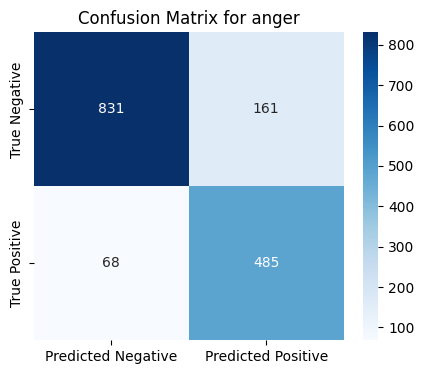

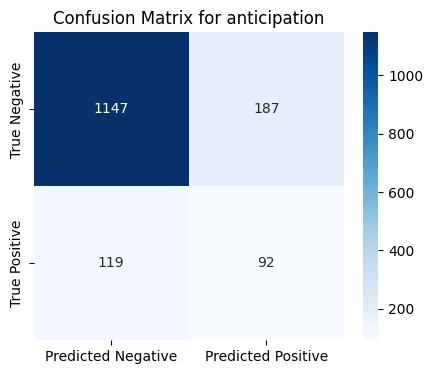

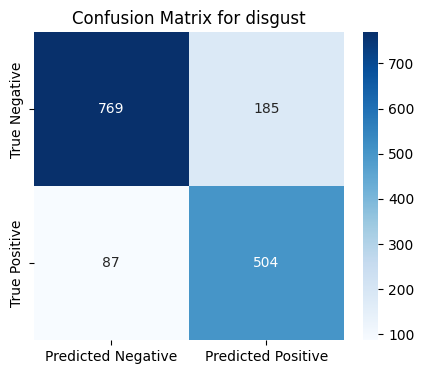

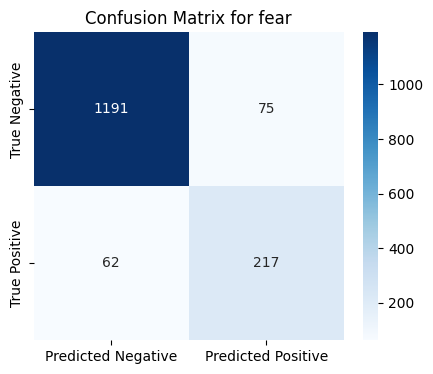

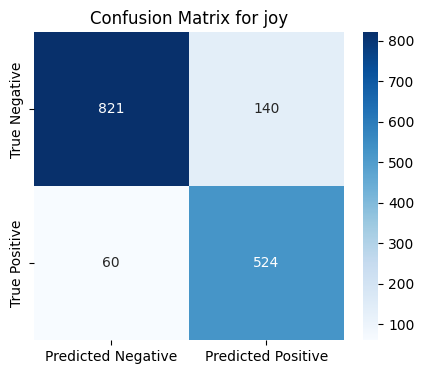

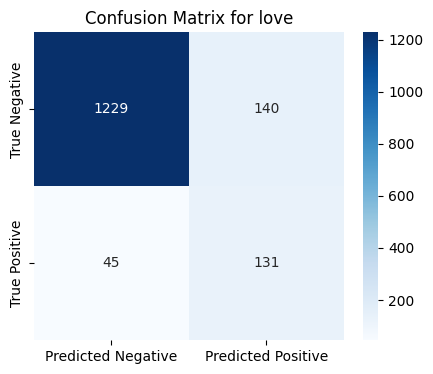

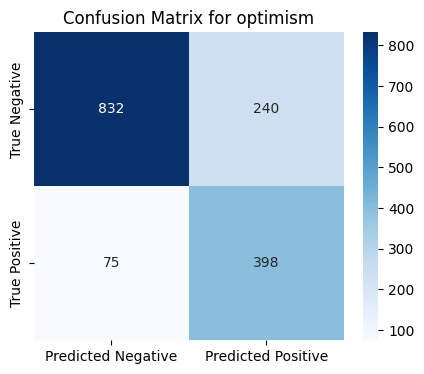

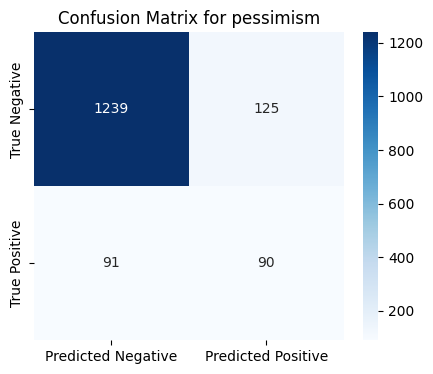

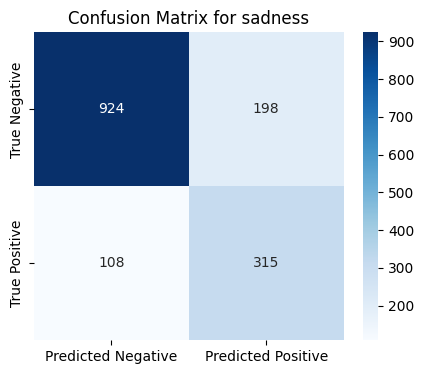

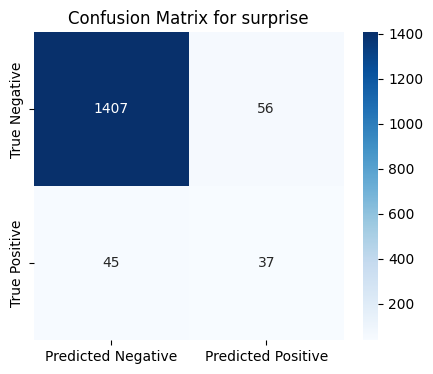

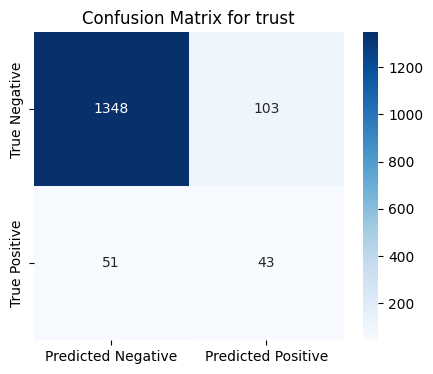

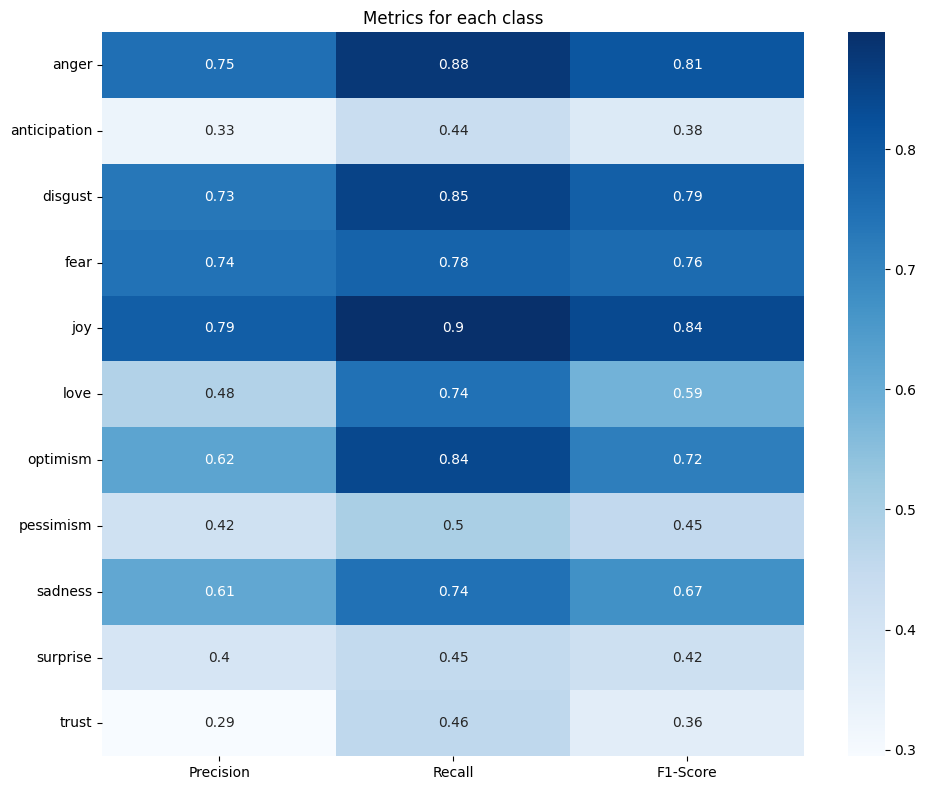

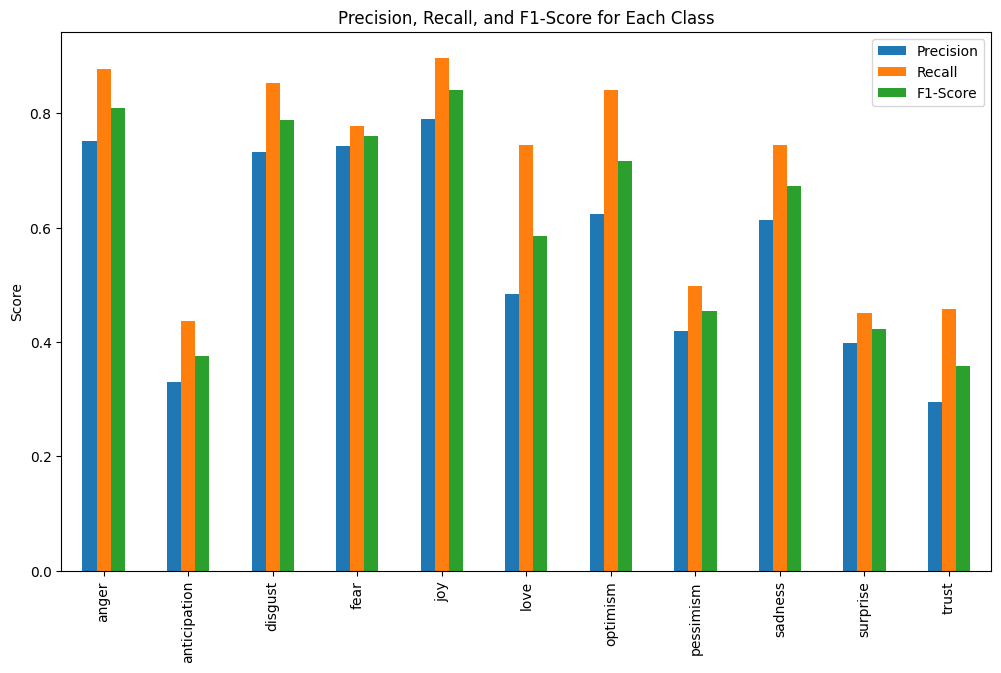

In [ ]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [ ]:
wandb.finish()

eval/accuracy,▁▂▄▅▅▆▆▇▇▇▇▇███▇█▇██▇██▇▇▇██████████▇███
eval/f1_macro,▁▂▃▅▅▇▇▇▇▇██████████████████████████████
eval/f1_micro,▁▂▄▆▆▇▇▇▇█▇█████████████████████████████
eval/loss,██▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂▃▂▃▃▄▂▂█▄▂▂▂▂▁▁▂▁▃▂▂▁▆▁▄▃▂▂▄▃▁▂▂▂▁▂▂▁▂▃
eval/samples_per_second,▇▆▇▆▅▅▇▆▁▅▇▆▇▇██▇█▆▇▇█▃█▅▆▇▇▅▆█▇▇▇▇▇▇█▇▆
eval/steps_per_second,▇▆▇▆▅▅▇▆▁▅▇▆▇▇██▇█▆▇▇█▃█▅▆▇▇▅▆█▇▇▇▇▇▇█▇▆
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
flant5_peft_model.push_to_hub("harpreetmann/flant5_QLORA_model_emotion_detection")

CommitInfo(commit_url='https://huggingface.co/harpreetmann/flant5_QLORA_model_emotion_detection/commit/1982e60d3ff51ca6617e3f566cdf8735f7fd6310', commit_message='Upload model', commit_description='', oid='1982e60d3ff51ca6617e3f566cdf8735f7fd6310', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
flant5_peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): T5ForSequenceClassification(
      (transformer): T5Model(
        (shared): Embedding(32128, 768)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 768)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): lora.Linear4bit(
                      (base_layer): Linear4bit(in_features=768, out_features=768, bias=False)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.01, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=768, out_features=128, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=128, out_features=768, bias=False)


# Test Set Predictions

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['out_proj', 'dense'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

peft_model_id = "harpreetmann/flant5_QLORA_model_emotion_detection"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                num_labels=11,
                                                                problem_type="multi_label_classification",
                                                                quantization_config=bnb_config)
base_model = prepare_model_for_kbit_training(base_model)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
base_model

In [ ]:
# Load the Lora model
inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

In [ ]:
inference_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): T5ForSequenceClassification(
      (transformer): T5Model(
        (shared): Embedding(32128, 768)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 768)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): lora.Linear4bit(
                      (base_layer): Linear4bit(in_features=768, out_features=768, bias=False)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.01, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=768, out_features=128, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=128, out_features=768, bias=False)
